In [1]:
# NB. Run this in Google colab NOT Jupyter lab.  https://colab.research.google.com/notebooks/intro.ipynb?utm_source=scs-index#recent=true
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
# Import libraries
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [218]:
sf_df = pd.read_csv('zillow_bedroom5_CA_3yr.csv',index_col=0)

In [219]:
# Make sure to set the zip codes down the rows
sf_df

,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018,1/31/2019,2/28/2019,3/31/2019,4/30/2019,5/31/2019,6/30/2019,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,3/31/2020,4/30/2020,5/31/2020,6/30/2020,7/31/2020,8/31/2020,9/30/2020,10/31/2020,11/30/2020,12/31/2020,1/31/2021,2/28/2021,3/31/2021,4/30/2021
Zip,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
94109,6379815,6372370,6453549,6646063,6858885.0,7040450.0,7138660,7209044,7233256,7256251,7253773,7238719,7147916,7159196,7143733,7089125,6958825,6876351,6923347,7014985,7115640,7123492,7139285,7123600,7130102,7087990,7039456,6988472,6974954,6945728,6842997,6719730,6607319,6551546,6482623,6424487,6368435
90250,826841,834064,841843,844301,844994.0,845722.0,850598,854415,857588,861477,862517,862017,860705,864220,866996,867276,866198,867572,871361,873817,878428,882342,887838,892650,896521,898013,898998,906411,916184,925211,931792,940967,950004,960570,972802,987544,1005165
94565,698872,704223,711652,716646,715352.0,714243.0,715311,714716,712668,711763,707846,705333,704134,709428,709876,705802,699531,692898,692557,694779,702902,702409,700127,700486,706772,709537,711181,718536,731190,745042,754411,763344,769304,783152,801987,819777,834249
90046,3628712,3630834,3630330,3636156,3635452.0,3638526.0,3640032,3643168,3632873,3628540,3602360,3575449,3566593,3593074,3633782,3623346,3598804,3564265,3566690,3560471,3564233,3560556,3588587,3621087,3648268,3642742,3625196,3651188,3692995,3741758,3765527,3793417,3821094,3847993,3862779,3875901,3894969
94501,1479045,1499370,1503243,1487025,1474190.0,1461113.0,1468738,1471075,1470779,1464889,1461041,1460942,1462092,1473742,1491092,1518361,1529940,1543751,1540484,1541071,1551401,1574517,1591243,1602981,1604312,1602327,1598709,1603235,1619133,1633813,1654649,1675906,1693925,1705341,1724443,1748584,1783701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96108,333961,329784,327179,316030,309208.0,304812.0,302871,302861,303868,307165,311662,313365,310171,304618,302799,302926,303749,304218,306242,307374,305100,301875,301042,302872,307571,314595,320960,327275,331674,335272,336816,338240,341125,343607,343323,342830,340645
96115,172763,173451,173671,175060,176762.0,178368.0,181314,184435,188072,189543,190203,189720,191303,192365,194239,193764,195997,197292,197301,195067,193906,193651,193475,193263,191704,190682,189201,188850,187035,185930,185503,186565,186810,187659,188893,190710,192817
95715,932989,923634,914349,898167,890271.0,879903.0,877501,871895,859896,877335,901690,918674,918259,936528,954031,949574,929441,917519,909798,905828,908255,915671,920134,920040,924268,920922,922789,945472,974128,1000746,1020505,1042680,1065684,1075408,1089492,1113302,1145371


# New Section

In [220]:
# set the random seed
np.random.seed(42)
#remove text column headers
data = sf_df.values
data_scaled = data/1000000

Scale the data


In [221]:
# Scale the data so that the model doesn't take too long to run (and to remove all units to ensure all features are on the same footing)
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(data)
# scaler.transform(data)
# data_scaled = scaler.transform(data)

In [211]:
# data_scaled.shape

Define training/testing/validation cells

In [222]:
train_stop = 1100
valid_stop = 1300
n_steps = len(sf_df.columns)
n_steps

37

In [223]:
# split the data into test, training and validation sets
X_train, y_train = data_scaled[:train_stop,:-1], data_scaled[:train_stop,-1]
X_valid, y_valid = data_scaled[train_stop:valid_stop,:-1], data_scaled[train_stop:valid_stop,-1]
X_test, y_test =   data_scaled[valid_stop:,:-1], data_scaled[valid_stop:,-1]

In [224]:
y_train = np.expand_dims(y_train,-1)
y_valid = np.expand_dims(y_valid,-1)
y_test = np.expand_dims(y_test,-1)
X_train = np.expand_dims(X_train,-1)
X_valid = np.expand_dims(X_valid,-1)
X_test = np.expand_dims(X_test,-1)

In [225]:
# Define a function to plot our sample
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, 0, 1])


In [226]:
X_valid[0,:,0].shape

(36,)

Saving figure time_series_plot


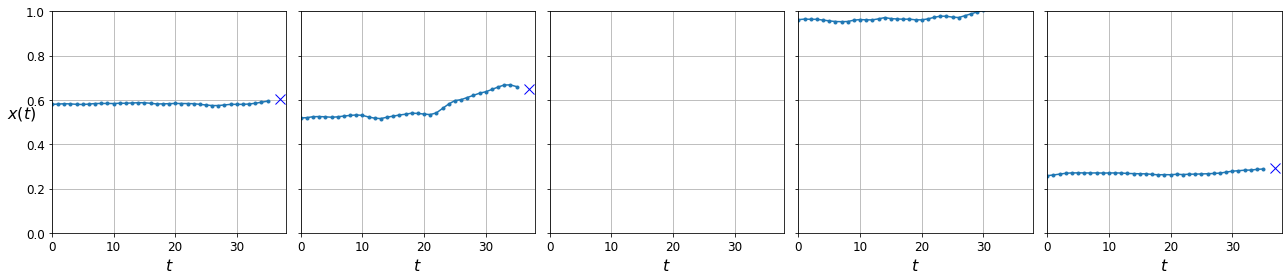

In [227]:
fig, axes = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(18, 4))
for col in range(5):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()
# 'x' in the graphs is what we are trying to predict

Establish a baseline

In [228]:
#Assume the base prediction is simply the last datapoint in the series
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.0005319341317649999

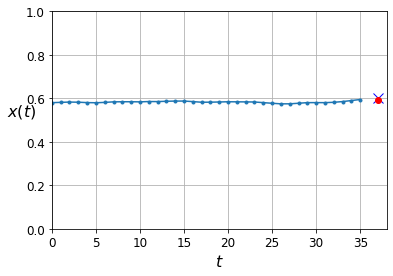

In [229]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [230]:
np.random.seed(42)
tf.random.set_seed(42)

In [231]:
# Deep RNN
model = keras.models.Sequential([
  keras.layers.LSTM(128, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(1)
    #This gives us 2 hidden layers and 1 layer at the end (the final number!. return_sequences=true ensures it passes the entire time series along at each layer)
])

In [232]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, None, 128)         66560     
_________________________________________________________________
lstm_16 (LSTM)               (None, None, 128)         131584    
_________________________________________________________________
lstm_17 (LSTM)               (None, 1)                 520       
Total params: 198,664
Trainable params: 198,664
Non-trainable params: 0
_________________________________________________________________


In [233]:
# We tried up to 20 epochs but the model started to exhibit signs of overfitting (training loss < validation loss) so we decided to stop at 6.
model.compile(loss=tf.keras.losses.mean_absolute_percentage_error, optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
35/35 [==============================] - 4s 34ms/step - loss: 35.4305 - val_loss: 18.4124
Epoch 2/20
35/35 [==============================] - 0s 10ms/step - loss: 21.9892 - val_loss: 15.2949
Epoch 3/20
35/35 [==============================] - 0s 10ms/step - loss: 20.6395 - val_loss: 15.1957
Epoch 4/20
35/35 [==============================] - 0s 10ms/step - loss: 19.8554 - val_loss: 16.5339
Epoch 5/20
35/35 [==============================] - 0s 10ms/step - loss: 19.9035 - val_loss: 15.9371
Epoch 6/20
35/35 [==============================] - 0s 10ms/step - loss: 19.7772 - val_loss: 16.0140
Epoch 7/20
35/35 [==============================] - 0s 10ms/step - loss: 19.8110 - val_loss: 14.4932
Epoch 8/20
35/35 [==============================] - 0s 10ms/step - loss: 19.6909 - val_loss: 14.8201
Epoch 9/20
35/35 [==============================] - 0s 10ms/step - loss: 19.8303 - val_loss: 14.8119
Epoch 10/20
35/35 [==============================] - 0s 11ms/step - loss: 19.8041 - val_los

In [234]:
model.evaluate(X_valid, y_valid)
# we want our loss function to be as close to 0 as possible

7/7 [==============================] - 0s 5ms/step - loss: 14.2652


14.265239715576172

In [235]:
model.save("bedroom5_trained.hdf5")

In [236]:
X_train[:,1:,:].shape

(1100, 35, 1)

In [237]:
y_train[:,].shape

(1100, 1)

In [238]:
# Model evaluations
model.evaluate(X_train,y_train)

35/35 [==============================] - 0s 5ms/step - loss: 19.3833


19.383262634277344

In [239]:
model.evaluate(X_valid,y_valid)

7/7 [==============================] - 0s 4ms/step - loss: 14.2652


14.265239715576172

In [240]:
model.evaluate(X_test,y_test)

4/4 [==============================] - 0s 5ms/step - loss: 15.0208


15.020797729492188

In [241]:
# X_train: Use expand_dims in order to give the y_train an extra dimension.
x_train_pred = np.concatenate((X_train[:,1:,:],np.expand_dims(y_train,-1)),axis=1)

In [242]:
# build y_train prediction
y_train_pred = model.predict(x_train_pred)
y_train_pred.shape

(1100, 1)

In [243]:
# X_valid: Use expand_dims in order to give the y_train an extra dimension.
x_valid_pred = np.concatenate((X_valid[:,1:,:],np.expand_dims(y_valid,-1)),axis=1)

In [244]:
# build y_valid prediction
y_valid_pred = model.predict(x_valid_pred)
y_valid_pred.shape

(200, 1)

In [245]:
# X_test: Use expand_dims in order to give the y_train an extra dimension.
x_test_pred = np.concatenate((X_test[:,1:,:],np.expand_dims(y_test,-1)),axis=1)

In [246]:
# build y_test prediction
y_test_pred = model.predict(x_test_pred)
y_test_pred.shape

(99, 1)

In [247]:
np.concatenate((y_pred_all,np.zeros((1399,37))),axis=1)


ValueError: ignored

In [248]:

# concatenate all three y_pred series together and append them to the original data
y_pred_all = np.concatenate((y_train_pred,y_valid_pred,y_test_pred),axis=0)
y_pred_all_df = pd.DataFrame(y_pred_all).astype('float')
y_pred_all_df*1000000

# np.mean(scaler.inverse_transform(np.concatenate((y_pred_all,np.zeros((1714,303))),axis=1))[:,0])

,0
0,999932.408333
1,988717.257977
2,827204.644680
3,999935.746193
4,999935.984612
...,...
1394,363086.462021
1395,196355.536580
1396,999018.788338
1397,999924.063683


In [249]:
sf_df['5/31/2021'] = y_pred_all_df[0].values

In [250]:
sf_df["max"]=sf_df.iloc[:,0:-2].max(axis=1)

In [251]:
sf_df["min"]=sf_df.iloc[:,0:-3].min(axis=1)


In [252]:
sf_df['5/31/2021_scaled'] = sf_df['5/31/2021']*(sf_df['max']-sf_df['min'])+sf_df['min']

In [253]:
sf_final_df = sf_df.drop(['max','min','5/31/2021'],axis=1)

In [254]:
sf_final_df.rename(columns={'5/31/2021_scaled':'5/31/2021'},inplace=True)
sf_final_df

,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018,1/31/2019,2/28/2019,3/31/2019,4/30/2019,5/31/2019,6/30/2019,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,3/31/2020,4/30/2020,5/31/2020,6/30/2020,7/31/2020,8/31/2020,9/30/2020,10/31/2020,11/30/2020,12/31/2020,1/31/2021,2/28/2021,3/31/2021,4/30/2021,5/31/2021
Zip,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
94109,6379815,6372370,6453549,6646063,6858885.0,7040450.0,7138660,7209044,7233256,7256251,7253773,7238719,7147916,7159196,7143733,7089125,6958825,6876351,6923347,7014985,7115640,7123492,7139285,7123600,7130102,7087990,7039456,6988472,6974954,6945728,6842997,6719730,6607319,6551546,6482623,6424487,6368435,7.256191e+06
90250,826841,834064,841843,844301,844994.0,845722.0,850598,854415,857588,861477,862517,862017,860705,864220,866996,867276,866198,867572,871361,873817,878428,882342,887838,892650,896521,898013,898998,906411,916184,925211,931792,940967,950004,960570,972802,987544,1005165,9.857308e+05
94565,698872,704223,711652,716646,715352.0,714243.0,715311,714716,712668,711763,707846,705333,704134,709428,709876,705802,699531,692898,692557,694779,702902,702409,700127,700486,706772,709537,711181,718536,731190,745042,754411,763344,769304,783152,801987,819777,834249,7.977940e+05
90046,3628712,3630834,3630330,3636156,3635452.0,3638526.0,3640032,3643168,3632873,3628540,3602360,3575449,3566593,3593074,3633782,3623346,3598804,3564265,3566690,3560471,3564233,3560556,3588587,3621087,3648268,3642742,3625196,3651188,3692995,3741758,3765527,3793417,3821094,3847993,3862779,3875901,3894969,3.875881e+06
94501,1479045,1499370,1503243,1487025,1474190.0,1461113.0,1468738,1471075,1470779,1464889,1461041,1460942,1462092,1473742,1491092,1518361,1529940,1543751,1540484,1541071,1551401,1574517,1591243,1602981,1604312,1602327,1598709,1603235,1619133,1633813,1654649,1675906,1693925,1705341,1724443,1748584,1783701,1.748566e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96108,333961,329784,327179,316030,309208.0,304812.0,302871,302861,303868,307165,311662,313365,310171,304618,302799,302926,303749,304218,306242,307374,305100,301875,301042,302872,307571,314595,320960,327275,331674,335272,336816,338240,341125,343607,343323,342830,340645,3.164968e+05
96115,172763,173451,173671,175060,176762.0,178368.0,181314,184435,188072,189543,190203,189720,191303,192365,194239,193764,195997,197292,197301,195067,193906,193651,193475,193263,191704,190682,189201,188850,187035,185930,185503,186565,186810,187659,188893,190710,192817,1.775812e+05
95715,932989,923634,914349,898167,890271.0,879903.0,877501,871895,859896,877335,901690,918674,918259,936528,954031,949574,929441,917519,909798,905828,908255,915671,920134,920040,924268,920922,922789,945472,974128,1000746,1020505,1042680,1065684,1075408,1089492,1113302,1145371,1.113053e+06


In [255]:
sf_final_df.to_csv('bedroom5_final_predicted_3yr.csv',index=True)